In [1]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
import sys
import time
import pickle
import torch
import torchvision.transforms.functional as tvf

from compressai.zoo.image import mbt2018_mean

torch.set_grad_enabled(False)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0')
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 4090


/ssd0/duan90/miniconda3/envs/cp311pt24/lib/python3.11/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


## Speed comparsion for CompressAI models

**Note:** this speed comparison includes the time to run neural network forward pass.

In [2]:
def test_on_kodak(model, verbose=None):
    model = model.to(device).eval()
    model.update(force=True)

    img_paths = list(Path('~/datasets/kodak').expanduser().rglob('*.png'))
    assert len(img_paths) == 24

    metrics = defaultdict(float)
    pbar = tqdm(img_paths, ascii=True, ncols=96, desc=f'{verbose}: ') if verbose else img_paths
    for impath in pbar:
        im = tvf.to_tensor(Image.open(impath).convert('RGB')).to(device).unsqueeze(0)

        enc_begin = time.time()
        compressed = model.compress(im)
        enc_end = time.time()
        outputs = model.decompress(compressed['strings'], compressed['shape'])
        dec_end = time.time()

        im_hat = outputs['x_hat']

        # encoding and decoding time
        metrics['enc-time'] += enc_end - enc_begin
        metrics['dec-time'] += dec_end - enc_end

        # estimate bpp and compute RGB PSNR
        num_bits = sys.getsizeof(pickle.dumps(compressed['strings'])) * 8
        bpp = num_bits / float(im.shape[2] * im.shape[3])
        psnr = -10.0 * (im - im_hat).square().mean().log10().item()
        # print(f'{impath.name}: PSNR={psnr:.2f}, BPP={bpp:.4f}')
        metrics['estimated-bpp'] += bpp
        metrics['rgb-psnr'] += psnr

    metrics = {k: v / len(img_paths) for k, v in metrics.items()}
    if verbose:
        for k, v in metrics.items():
            if 'time' in k:
                print(f'{k}: {v:.6f} s')
            else:
                print(f'{k}: {v:.4f}')
    return metrics


In [3]:
print('='*96)
model = mbt2018_mean(quality=1, pretrained=True)
test_on_kodak(model, verbose=None) # warmup
metrics_original = test_on_kodak(model, verbose='Using list/vectors')

print('='*96)
from compressai_models import MyGaussianConditional
model.gaussian_conditional = MyGaussianConditional(None)
metrics_repo = test_on_kodak(model, verbose='Using numpy (this repo)')


Using list/vectors: 100%|#######################################| 24/24 [00:01<00:00, 15.57it/s]


enc-time: 0.025499 s
dec-time: 0.028446 s
estimated-bpp: 0.1253
rgb-psnr: 27.6996


Using numpy (this repo): 100%|##################################| 24/24 [00:00<00:00, 35.07it/s]

enc-time: 0.010926 s
dec-time: 0.007627 s
estimated-bpp: 0.1253
rgb-psnr: 27.6996


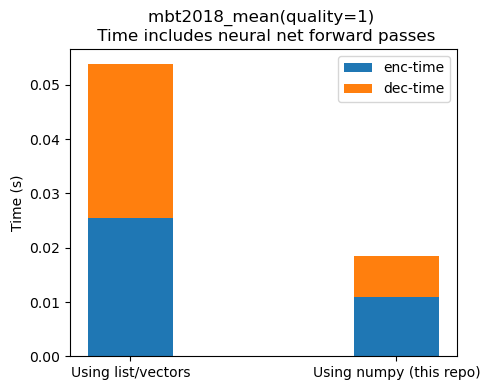

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))

# stacked bar plot
bottom = torch.zeros(2)
for k in ['enc-time', 'dec-time']:
    x_labels = ['Using list/vectors', 'Using numpy (this repo)']
    y_values = torch.tensor([metrics_original[k], metrics_repo[k]])
    ax.bar(x_labels, y_values, width=0.32, label=k, bottom=bottom, align='center')
    bottom = bottom + y_values

plt.title('mbt2018_mean(quality=1) \n Time includes neural net forward passes')
plt.ylabel('Time (s)')
plt.tight_layout()
plt.legend()
plt.savefig('figures/model-time.png')
